In [261]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F


In [262]:
import imageio
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [263]:
print("Gym version:", gym.__version__)
print("Torch version:", torch.__version__)

Gym version: 0.26.2
Torch version: 1.13.1+cu117


<h3>Use Cuda</h3>

In [264]:
# USE_CUDA = torch.cuda.is_available()
USE_CUDA = "cpu"
# Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).to(USE_CUDA) if USE_CUDA else autograd.Variable(*args, **kwargs)
torch_tensor = lambda *args, **kwargs: torch.tensor(*args, **kwargs).to(USE_CUDA) if USE_CUDA else torch.tensor(*args, **kwargs)

<h2>Cart Pole Environment</h2>

## Action Space

| Num | Action                   |
|-----|--------------------------|
| 0   | Push cart to the left    |
| 1   | Push cart to the right   |


## Observation Space

| Num | Observation              | Min           | Max           |
|-----|--------------------------|---------------|---------------|
| 0   | Cart Position            | -4.8          | 4.8           |
| 1   | Cart Velocity            | -Inf          | Inf           |
| 2   | Pole Angle               | ~ -0.418 rad  | ~ 0.418 rad   |
| 3   | Pole Angular Velocity    | -Inf          | Inf           |

In [265]:
env_id = "CartPole-v0"
env = gym.make(env_id)

In [266]:
# Testing the environment
state, info = env.reset(seed=42)
for i in range(10):
   # action = policy(observation)  # User-defined policy function
   # NOTE: random policy
   action = env.action_space.sample()
   next_state, reward, done, truncated, info = env.step(action)
   print(f"Step {i}:",next_state, reward, done, truncated, info)

   state = next_state

   if done or truncated:
      observation, info = env.reset()
env.close()

Step 0: [ 0.02727336 -0.20172954  0.03625453  0.32351476] 1.0 False False {}
Step 1: [ 0.02323877 -0.00714208  0.04272482  0.04248186] 1.0 False False {}
Step 2: [ 0.02309593 -0.20284982  0.04357446  0.34833285] 1.0 False False {}
Step 3: [ 0.01903893 -0.00837385  0.05054112  0.06970263] 1.0 False False {}
Step 4: [ 0.01887146 -0.2041826   0.05193517  0.37789345] 1.0 False False {}
Step 5: [ 0.0147878  -0.40000218  0.05949304  0.68648887] 1.0 False False {}
Step 6: [ 0.00678776 -0.20575435  0.07322282  0.41311327] 1.0 False False {}
Step 7: [ 0.00267267 -0.01174257  0.08148509  0.14438367] 1.0 False False {}
Step 8: [ 0.00243782  0.18212362  0.08437276 -0.12152059] 1.0 False False {}
Step 9: [ 0.00608029  0.37594175  0.08194234 -0.38643745] 1.0 False False {}


In [267]:
# Checking Environment
print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)
print("Rewards:", env.reward_range)

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Rewards: (-inf, inf)


<h2>Replay Buffer</h2>

In [268]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    # Add a new experience to the buffer
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    # Function to transform to tensors
    def toTensor(self, states, actions, rewards, next_states, dones):
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).view(-1, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).view(-1, 1)
        next_states = torch.tensor(next_states, dtype=torch.float32, requires_grad=False)
        dones = torch.tensor(dones, dtype=torch.float32).view(-1, 1)

        return states, actions, rewards, next_states, dones

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        # TODO: Add the conversion to Pytorch tensor here
        # In which format I need it?

        # return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
        return self.toTensor(states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

In [269]:
# Check the ReplayBuffer is working
replay_buffer = ReplayBuffer(1000)

state, info = env.reset(seed=42)
for i in range(10):
   # action = policy(observation)  # User-defined policy function
   # NOTE: random policy
   action = env.action_space.sample()
   next_state, reward, done, truncated, info = env.step(action)
   # print(f"Step {i}:",next_state, reward, done, truncated, info)

   # Push tuples to the ExperienceReplay
   replay_buffer.push(state, action, reward, next_state, done)

   state = next_state

   if done or truncated:
      observation, info = env.reset()
env.close()

states, actions, rewards, next_states, dones = replay_buffer.sample(5)
print(len(replay_buffer))
print(states.shape)
print(actions.shape)
print(rewards.shape)
print(next_states.shape)
print(dones.shape)

10
torch.Size([5, 4])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 4])
torch.Size([5, 1])


<h2>Epsilon greedy exploration</h2>

In [270]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

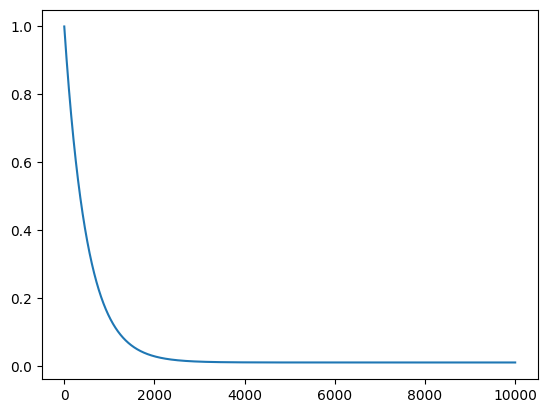

In [271]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Deep Q Network</h2>

In [272]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.choice(range(env.action_space.n))
        else:
            with torch.no_grad():
                state   = torch.tensor(state, dtype=torch.float32, requires_grad=False).unsqueeze(0)
                q_values = self.forward(state)
                return int(torch.argmax(q_values, dim=1))
    
        # if random.random() > epsilon:
        #     state   = torch.tensor(state, dtype=torch.float32, requires_grad=False).unsqueeze(0)
        #     # state   = torch_tensor(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
        #     q_value = self.forward(state)
        #     action  = q_value.max(1)[1].data[0]
        # else:
        #     action = random.randrange(env.action_space.n)
        # return action

In [273]:
model = DQN(env.observation_space.shape[0], env.action_space.n)

# if USE_CUDA:
#     model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

In [274]:
# Network forward pass
input_check = torch.randn(5, 4)
q_values = model(input_check)
print(q_values)
print(q_values.shape)

tensor([[ 0.1525, -0.0712],
        [ 0.1375, -0.0895],
        [ 0.1136, -0.0823],
        [ 0.0072, -0.0557],
        [ 0.1835, -0.1897]], grad_fn=<AddmmBackward0>)
torch.Size([5, 2])


In [275]:
# Actor
input_check = torch.randn(1, 4)
action = model.act(input_check, epsilon=0.5)
print(action)

1


<h2>Computing Temporal Difference Loss</h2>

In [276]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # NOTE: the loss is only calculated in the j-th q-value(state,a_j)
    # q_values from the model
    q_values      = model(state)
    q_value       = q_values.gather(1, action).squeeze(1)

    # NOTE: I don't if I should don't allow to calculate gradients in this step
    # Yep, I think to differentiate between the old a new weights, but for now
    # it's ok to keep it in this way
    # y_j calculation: expected q_value
    next_q_values    = model(next_state)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (expected_q_value.data - q_value).pow(2).mean()

    # loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [277]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

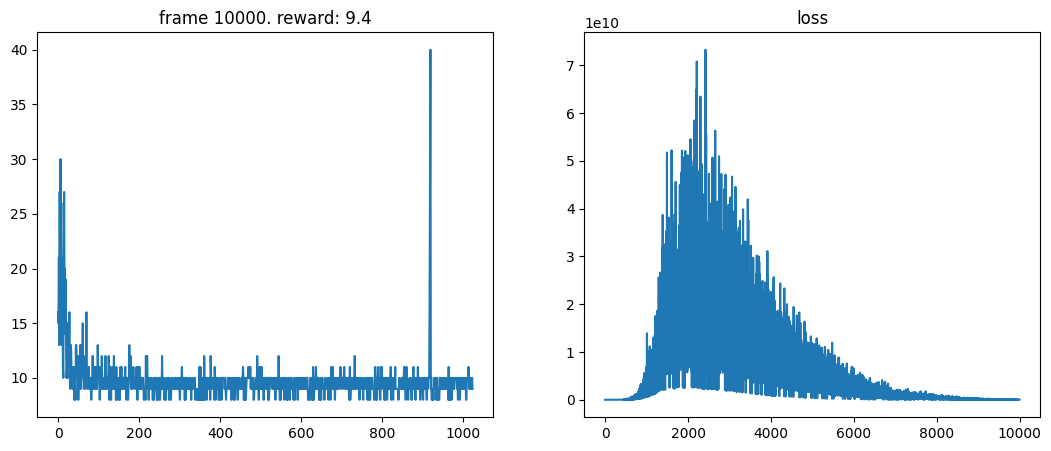

In [279]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state, info = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon) # NOTE: policy
    
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state, info = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
    
    # NOTE: At the begining, it needed some iteration to fill
    # the replay buffer
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

<p><hr></p>

<h1>Atari Environment</h1>

In [13]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

ModuleNotFoundError: No module named 'common'

In [23]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [24]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [25]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [26]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

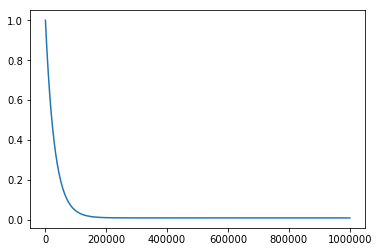

In [27]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

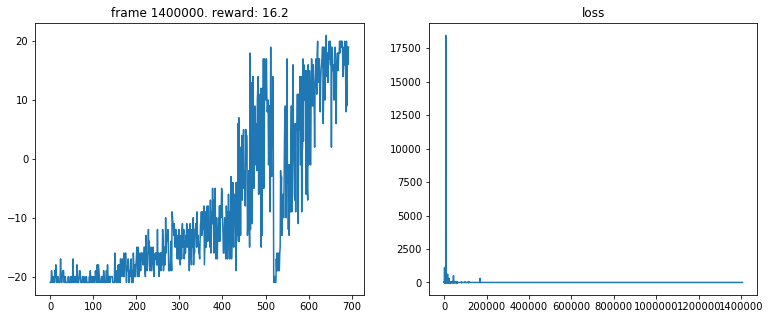

In [33]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)